In [1]:
!pip install pandas openpyxl

In [ ]:
import pandas as pd
import random
import numpy as np

# Load data
mata_kuliah_df = pd.read_excel('ujian ganjil.xlsx', sheet_name='Mata Kuliah')
pengawas_df = pd.read_excel('ujian ganjil.xlsx', sheet_name='Pengawas')
ruangan_df = pd.read_excel('ujian ganjil.xlsx', sheet_name='Ruangan')
hari_df = pd.read_excel('ujian ganjil.xlsx', sheet_name='Hari')
sesi_df = pd.read_excel('ujian ganjil.xlsx', sheet_name='Sesi')

# Siapkan list dari DataFrame
daftar_mk       = mata_kuliah_df[['Mata Kuliah', 'Kelas']].apply(tuple, axis=1).tolist()
daftar_ruangan  = ruangan_df['Ruangan'].unique().tolist()
daftar_pengawas = pengawas_df['Pengawas'].unique().tolist()
daftar_hari     = hari_df['Hari'].tolist()
daftar_sesi     = sesi_df['Sesi'].tolist()

In [ ]:
from collections import defaultdict

def generate_schedule(daftar_mk, daftar_pengawas, daftar_ruangan, daftar_hari, daftar_sesi):

    total_slot = len(daftar_hari) * len(daftar_sesi) * len(daftar_ruangan)

    kumpulan_mk = []
    while len(kumpulan_mk) < total_slot:
        kumpulan_mk.extend(daftar_mk)
    kumpulan_mk = kumpulan_mk[:total_slot]
    random.shuffle(kumpulan_mk)

    jadwal = []
    index = 0

    for hari in daftar_hari:
        for sesi in daftar_sesi:
            for ruangan in daftar_ruangan:
                mk, kelas = kumpulan_mk[index]
                pengawas = random.choice(daftar_pengawas)
                jadwal.append([hari, sesi, mk, kelas, ruangan, pengawas])
                index += 1

    data_df = pd.DataFrame(jadwal, columns=['Hari', 'Sesi', 'Mata Kuliah', 'Kelas', 'Ruangan', 'Pengawas'])
    return data_df

In [ ]:
data_df = generate_schedule(daftar_mk, daftar_pengawas, daftar_ruangan, daftar_hari, daftar_sesi)
display(data_df)

,Hari,Sesi,Mata Kuliah,Kelas,Ruangan,Pengawas
0,1,1,Rekayasa Perangkat Lunak,A,F4.1,"Ir. Dr.Eng. Herman Tolle, S.T., M.T."
1,1,1,Pengantar Keilmuan Komputer,D,F4.2,"Komang Candra Brata, S,Kom., M.T., M.Sc."
2,1,1,Metode Numerik,B,F4.3,"Indriati, S.T., M.Kom."
3,1,1,Agama,N1L,F4.4,"Agus Gozali, S.Pd., M.Li."
4,1,1,Jaringan Komputer,F,F4.5,"Mohammad Muallif, M.Ag,"
...,...,...,...,...,...,...
171,4,4,Kecerdasan Buatan,B,F4.7,"Dr. Lailil Muflikhah, S.Kom., M.Sc."
172,4,4,Jaringan Komputer,G,F4.8,"Adhitya Bhawiyuga, S.Kom., M.Sc."
173,4,4,Kalkulus,C,F4.9,"Zenitha Kurnia Putri, S.i.kom., M.i.kom.,"
174,4,4,Realitas Berimbuh dan Maya,A,F4.10,"Mohammad Muallif, M.Ag,"


In [ ]:
def calculate_cost(data_df, constraints):
    cost = 0

    # Constraint 2: Pengawas bentrok (sama sesi, hari, pengawas)
    df_pengawas = data_df.groupby(['Hari', 'Sesi', 'Pengawas']).size().reset_index(name='jumlah')
    df_pengawas = df_pengawas[df_pengawas['jumlah'] > 1]
    cost += ((df_pengawas['jumlah'] - 1) * constraints[1]).sum()

    # Constraint 3: Mata kuliah tidak seragam hari dan sesi
    df_mk = data_df.groupby('Mata Kuliah')[['Hari', 'Sesi']].nunique().reset_index()
    df_mk = df_mk.query('(Hari > 1) | (Sesi > 1)').copy()
    cost += (((df_mk['Hari'] + df_mk['Sesi']) - 2) * constraints[2]).sum()

    # Constraint 6 (Soft): MK 1 kelas tidak seragam hari
    mk_kelas_hari = {}
    for index, row in data_df.iterrows():
        mk = row['Mata Kuliah']
        kelas = row['Kelas']
        hari = row['Hari']
        if mk not in mk_kelas_hari:
            mk_kelas_hari[mk] = {}
        if kelas not in mk_kelas_hari[mk]:
            mk_kelas_hari[mk][kelas] = hari
        elif mk_kelas_hari[mk][kelas] != hari:
            cost += constraints[3]

    fitness = 1 / (1 + cost)
    return cost, fitness

In [ ]:
# # Constraints dan bobot
constraints = {
    1: 0.05,
    2: 0.05,
    3: 0.001  # soft constraint
}

In [ ]:
# Fungsi cek bentrok dan beri skor sesuai constraint

def cek_bentrok_pengawas(data_df, constraints):
    df = data_df.groupby(['Hari', 'Sesi', 'Pengawas']).size().reset_index(name='jumlah')
    df = df.query('jumlah > 1')  # Bentrok
    df['Skor'] = (df['jumlah'] - 1) * constraints[1]
    df['Jenis'] = 'Pengawas Bentrok'
    return df[['Jenis', 'Hari', 'Sesi', 'Pengawas', 'Skor']]

def cek_mk_tidak_seragam(data_df, constraints):
    df = data_df.groupby('Mata Kuliah')[['Hari', 'Sesi']].nunique().reset_index()
    df = df.query('(Hari > 1) | (Sesi > 1)').copy()
    df['Skor'] = ((df['Hari'] + df['Sesi']) - 2) * constraints[2]
    df['Jenis'] = 'MK Tidak Seragam'
    return df[['Jenis', 'Mata Kuliah', 'Hari', 'Sesi', 'Skor']]

    for key in sesi_kelas_count:
        kelas_count = sesi_kelas_count[key]
        ruangan_count = len(sesi_ruangan[key])
        if kelas_count != 14:
            df.append({
                'Jenis': 'Jumlah Kelas Tidak Sesuai',
                'Hari': key[0], 'Sesi': key[1],
                'Ruangan': '',
                'Skor': constraints[5] * abs(14 - kelas_count)
            })
        if ruangan_count != kelas_count:
            df.append({
                'Jenis': 'Duplikasi Ruangan',
                'Hari': key[0], 'Sesi': key[1],
                'Ruangan': '',
                'Skor': constraints[5] * (kelas_count - ruangan_count)
            })

    return pd.DataFrame(df)

def cek_mk_kelas_hari(data_df, constraints):
    mk_kelas_hari = {}
    df = []
    for _, row in data_df.iterrows():
        mk, kelas, hari = row['Mata Kuliah'], row['Kelas'], row['Hari']
        if mk not in mk_kelas_hari:
            mk_kelas_hari[mk] = {}
        if kelas not in mk_kelas_hari[mk]:
            mk_kelas_hari[mk][kelas] = hari
        elif mk_kelas_hari[mk][kelas] != hari:
            df.append({
                'Jenis': 'MK 1 Kelas Tidak Seragam',
                'Mata Kuliah': mk,
                'Kelas': kelas,
                'Hari': hari,
                'Sesi': row['Sesi'],
                'Skor': constraints[3]
            })
    return pd.DataFrame(df)

# Fungsi utama untuk mengecek semua pelanggaran
def cek_semua_bentrok(data_df, constraints):
    df_list = [
        cek_bentrok_pengawas(data_df, constraints),
        cek_mk_tidak_seragam(data_df, constraints),
        cek_mk_kelas_hari(data_df, constraints)
    ]
    return pd.concat(df_list, ignore_index=True)

# Jalankan pengecekan
pelanggaran_df = cek_semua_bentrok(data_df, constraints)
total_cost = pelanggaran_df['Skor'].sum()
fitness = 1 / (1 + total_cost)

# Fungsi untuk menampilkan tabel ringkasan per jenis pelanggaran
def tampilkan_jenis_pelanggaran(pelanggaran_df, jenis_pelanggaran):
    df_jenis = pelanggaran_df[pelanggaran_df['Jenis'] == jenis_pelanggaran].copy()

    # Buang kolom yang semua nilainya NaN supaya tampilan rapi
    df_jenis = df_jenis.dropna(axis=1, how='all')

    styled_table = df_jenis.style.set_caption(f"🚨 **Ringkasan Pelanggaran: {jenis_pelanggaran}**")\
        .background_gradient(subset=['Skor'], cmap='Reds')\
        .format({'Skor': '{:.2f}'})\
        .hide(axis="index")\
        .set_table_styles([
            {'selector': 'caption', 'props': [('color', '#d32f2f'), ('font-size', '18px'), ('font-weight', 'bold')]},
            {'selector': 'table', 'props': [('border-collapse', 'collapse')]},
            {'selector': 'th', 'props': [('background-color', '#547792'), ('padding', '10px'), ('text-align', 'center'), ('font-size', '14px')]},
            {'selector': 'td', 'props': [('padding', '8px'), ('text-align', 'center')]},
        ])
    display(styled_table)

# Menampilkan seluruh jenis pelanggaran
jenis_list = pelanggaran_df['Jenis'].unique()
for jenis in jenis_list:
    tampilkan_jenis_pelanggaran(pelanggaran_df, jenis)

# Ringkasan akhir
print(f"\nBest Cost: {total_cost:.2f}")
print(f"Fitness: {fitness:.4f}")

<ipython-input-13-d67f47a4a58d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Skor'] = (df['jumlah'] - 1) * constraints[1]
<ipython-input-13-d67f47a4a58d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Jenis'] = 'Pengawas Bentrok'


Jenis,Hari,Sesi,Pengawas,Skor
Pengawas Bentrok,1,3,"Eko Setiawan, S.T., M.T., M.Eng., Ph.D.",0.05
Pengawas Bentrok,1,4,"Eriq Muhammad Adams Jonemaro, S.T., M.Kom.",0.05
Pengawas Bentrok,2,4,"Dr. Lailil Muflikhah, S.Kom., M.Sc.",0.05
Pengawas Bentrok,2,4,"Satrio Agung Wicaksono, S.Kom., M.Kom.",0.05
Pengawas Bentrok,3,1,"Barlian Henryranu Prasetio, S.T., M.T., Ph.D.",0.05
Pengawas Bentrok,3,2,"Dr. Diva Kurnianingtyas, S.Kom.",0.05
Pengawas Bentrok,3,3,"Faiza Alif Fakhrina, S.kom., M.t.,",0.05
Pengawas Bentrok,3,4,"Drs. Muh. Arif Rahman, M.Kom.",0.05
Pengawas Bentrok,3,4,"Ifan Taufikkurohman,",0.05


Jenis,Hari,Sesi,Skor,Mata Kuliah
MK Tidak Seragam,1,2,0.05,Administrasi Sistem Server
MK Tidak Seragam,4,4,0.30,Agama
MK Tidak Seragam,3,3,0.20,Arsitektur dan Organisasi Komputer
MK Tidak Seragam,4,4,0.30,Bahasa Inggris
MK Tidak Seragam,4,4,0.30,Basis Data
MK Tidak Seragam,2,2,0.10,Data Engineering
MK Tidak Seragam,3,3,0.20,Desain dan Analisis Algoritma
MK Tidak Seragam,3,3,0.20,Etika Profesi
MK Tidak Seragam,2,2,0.10,Grafika Komputer
MK Tidak Seragam,3,3,0.20,Interaksi Manusia dan Komputer


Jenis,Hari,Sesi,Skor,Mata Kuliah,Kelas
MK 1 Kelas Tidak Seragam,2,4,0.00,Agama,N1D
MK 1 Kelas Tidak Seragam,3,4,0.00,Agama,N1L
MK 1 Kelas Tidak Seragam,4,1,0.00,Agama,N4A
MK 1 Kelas Tidak Seragam,4,3,0.00,Agama,N1C
MK 1 Kelas Tidak Seragam,4,3,0.00,Agama,N1E



Best Cost: 6.06
Fitness: 0.1417


In [ ]:
def aco_algorithm(data_df, constraints,
                  num_ants, num_iterations,
                  evaporation_rate, alpha, beta,
                  tau_0, Q, local_evap_rate=0.1):

    # --- Persiapan data ---
    mata_kuliah_list = mata_kuliah_df['Mata Kuliah'].unique()
    slot_list = [(h, s) for h in hari_df['Hari'] for s in sesi_df['Sesi']]
    ruangan_list = ruangan_df['Ruangan'].tolist()

    # Inisialisasi feromon global per (mk, slot)
    pheromone = {
        mk: {slot: tau_0 for slot in slot_list}
        for mk in mata_kuliah_list
    }

    global_best_solution = None
    global_best_cost = float('inf')

    for iteration in range(num_iterations):
        # Kita akan kumpulkan seluruh delta pheromon lokal di iterasi ini
        delta_global = {
            mk: {slot: 0.0 for slot in slot_list}
            for mk in mata_kuliah_list
        }

        # --- Setiap semut membangun solusi ---
        for ant in range(num_ants):
            solution = []
            slot_fill = {slot: 0 for slot in slot_list}
            ruangan_per_slot = {slot: ruangan_list.copy() for slot in slot_list}
            tabu = set()  # (mk, slot) yang sudah dipakai semut ini

            # Acak order mata kuliah
            for _, row in data_df.sample(frac=1).iterrows():
                mk = row['Mata Kuliah']
                kelas = row['Kelas']

                # Hitung probabilitas per slot
                probs = []
                for slot in slot_list:
                    if slot_fill[slot] < len(ruangan_list) and (mk, slot) not in tabu:
                        pher = pheromone[mk][slot] ** alpha
                        heur = 1  # Initialize heur here
                        for i, constraint in enumerate(list(constraints.values())[1:], start=1):
                            heur *= (1 / (1 + constraint)) ** beta
                        probs.append((slot, pher * heur))

                # Pilih slot
                if not probs or sum(p for _, p in probs) == 0:
                    chosen_slot = random.choice(
                        [s for s in slot_list if slot_fill[s] < len(ruangan_list)]
                    )
                else:
                    total = sum(p for _, p in probs)
                    weights = [p/total for _, p in probs]
                    slots = [s for s, _ in probs]
                    chosen_slot = random.choices(slots, weights, k=1)[0]

                # Tandai, ambil ruangan, dan simpan
                slot_fill[chosen_slot] += 1
                tabu.add((mk, chosen_slot))
                ruang = ruangan_per_slot[chosen_slot].pop(0)

                solution.append({
                    'Mata Kuliah': mk,
                    'Kelas': kelas,
                    'Pengawas': random.choice(pengawas_df['Pengawas'].tolist()),
                    'Ruangan': ruang,
                    'Hari': chosen_slot[0],
                    'Sesi': chosen_slot[1]
                })

            # Buat DataFrame solusi semut ini
            sol_df = pd.DataFrame(solution)
            cost, fitness = calculate_cost(sol_df, constraints)

            # Simpan global best
            if cost < global_best_cost:
                global_best_cost = cost
                global_best_solution = sol_df.copy()

            # --- Hitung dan simpan Δτ lokal semut ini ---
            if cost > 0:
                deposit = Q / cost
                for _, row in sol_df.iterrows():
                    mk = row['Mata Kuliah']
                    slot = (row['Hari'], row['Sesi'])
                    delta_global[mk][slot] += deposit # Menghitung feromon Global

        # --- Pembaruan Evaporasi Feromon ---
        for mk in pheromone:
            for slot in pheromone[mk]:
                # evaporasi ke tau_0
                pheromone[mk][slot] = evaporation_rate * tau_0 \
                                      + delta_global[mk][slot]

        # (opsional) Normalisasi feromon agar tetap dalam skala [tau_0, 1]
        max_val = max(pheromone[mk][slot] for mk in pheromone for slot in pheromone[mk])
        if max_val > 0:
            for mk in pheromone:
                for slot in pheromone[mk]:
                    pheromone[mk][slot] /= max_val

    return global_best_solution, global_best_cost

# BATAS 2

In [ ]:
# num_ants_list = [5, 10, 15]
# evaporation_rate_list = [0.01, 0.05, 0.09]
# alpha_list = [0.01, 0.05, 1, 2]
# beta_list = [0.01, 0.05, 1, 2]
# tau_list = [0.01, 0.1, 0.5]
# Q_list = [0.5, 1, 3]
# num_iterations_list = [10, 50, 100]

In [ ]:
import time

# List nilai parameter yang akan diuji
num_ants_list = [5, 10, 15, 20, 25, 30]
evaporation_rate_list = [0.01, 0.05, 0.09, 0.1, 0.3, 0.5, 0.7, 0.9]
alpha_list = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 3]
beta_list = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 3]
tau_list = [0.001, 0.01, 0.05, 0.1, 0.5, 0.9, 1, 2]
Q_list = [0.1, 0.5, 0.9, 1, 2, 3, 4, 5]
num_iterations_list = [10, 30, 50, 100, 500, 1000, 1500]

# === Parameter Default Awal ===
best_params = {
    'num_ants': 5,
    'evaporation_rate': 0.01,
    'alpha': 0.01,
    'beta': 0.01,
    'tau': 0.01,
    'Q': 0.5,
    'num_iterations': 10
}

# === Dictionary untuk Menyimpan Hasil Tuning ===
tuning_logs = {}

# === Fungsi Tuning Satu Parameter ===
def tune_parameter(param_name, param_values):
    results = []

    for value in param_values:
        temp_params = best_params.copy()
        temp_params[param_name] = value

        start_time = time.time()
        best_solution, best_cost = aco_algorithm(
            data_df, constraints,
            temp_params['num_ants'],
            temp_params['num_iterations'],
            temp_params['evaporation_rate'],
            temp_params['alpha'],
            temp_params['beta'],
            temp_params['tau'],
            temp_params['Q']
        )
        end_time = time.time()

        duration = end_time - start_time
        fitness = 1 / (best_cost + 1)

        results.append({
            'value': value,
            'cost': best_cost,
            'fitness': fitness,
            'duration': duration
        })

        print(f"Parameter: {param_name}, Value: {value} - Cost: {best_cost:.2f}, Fitness: {fitness:.8f}, Duration: {duration:.2f} seconds")

    df_results = pd.DataFrame(results)
    best_value = df_results.loc[df_results['fitness'].idxmax(), 'value']
    best_cost = df_results.loc[df_results['fitness'].idxmax(), 'cost']
    best_duration = df_results.loc[df_results['fitness'].idxmax(), 'duration']

    print(f"Best {param_name}: {best_value} - Cost: {best_cost:.2f} - Fitness: {1/(best_cost + 1):.4f} - Duration: {best_duration:.2f} seconds")

    return best_value, df_results

# === Jalankan Tuning Setiap Parameter ===
best_params['num_ants'], tuning_logs['num_ants'] = tune_parameter('num_ants', num_ants_list)
best_params['evaporation_rate'], tuning_logs['evaporation_rate'] = tune_parameter('evaporation_rate', evaporation_rate_list)
best_params['alpha'], tuning_logs['alpha'] = tune_parameter('alpha', alpha_list)
best_params['beta'], tuning_logs['beta'] = tune_parameter('beta', beta_list)
best_params['tau'], tuning_logs['tau'] = tune_parameter('tau', tau_list)
best_params['Q'], tuning_logs['Q'] = tune_parameter('Q', Q_list)
best_params['num_iterations'], tuning_logs['num_iterations'] = tune_parameter('num_iterations', num_iterations_list)

# === Ringkasan Hasil Tuning ===
summary = []
for param_name, df in tuning_logs.items():
    best_idx = df['fitness'].idxmax()
    best_val = df.loc[best_idx, 'value']
    best_cost = df.loc[best_idx, 'cost']
    best_fitness = df.loc[best_idx, 'fitness']
    best_time = df.loc[best_idx, 'duration']
    summary.append({
        'Parameter': param_name,
        'Best Value': best_val,
        'Best Cost': best_cost,
        'Best Fitness': best_fitness,
        'Exec Time (s)': best_time
    })

summary_df = pd.DataFrame(summary)

# Tampilkan tabel ringkasan hasil tuning
display(
    summary_df
    .style
    .set_caption("📊 Ringkasan Hasil Tuning Parameter ACO")
    .format({
        'Best Cost': '{:.2f}',
        'Best Fitness': '{:.10f}',
        'Exec Time (s)': '{:.2f}'
    })
)

# === Jalankan Ulang ACO dengan Kombinasi Parameter Terbaik ===
best_params_final = {row['Parameter']: row['Best Value'] for _, row in summary_df.iterrows()}

start_time = time.time()
best_solution, best_cost = aco_algorithm(
    data_df, constraints,
    int(best_params_final['num_ants']),
    int(best_params_final['num_iterations']),
    best_params_final['evaporation_rate'],
    best_params_final['alpha'],
    best_params_final['beta'],
    best_params_final['tau'],
    best_params_final['Q']
)
end_time = time.time()

execution_time = end_time - start_time
best_fitness = 1 / (best_cost + 1)

print("\n✅ Hasil ACO Menggunakan Parameter Terbaik:")
print(f"Best Cost         : {best_cost:.2f}")
print(f"Best Fitness      : {best_fitness:.4f}")
print(f"Execution Time(s) : {execution_time:.2f}")

# === Tampilkan Jadwal Final ===
jadwal_final = best_solution[['Hari', 'Sesi', 'Ruangan', 'Mata Kuliah', 'Kelas', 'Pengawas']].sort_values(by=['Hari', 'Sesi'])

print("=== 📅 Jadwal Ujian Akhir Semester Terbaik ===")
display(jadwal_final)

Parameter: num_ants, Value: 5 - Cost: 6.21, Fitness: 0.13879251, Duration: 2.27 seconds
Parameter: num_ants, Value: 10 - Cost: 6.10, Fitness: 0.14076577, Duration: 5.31 seconds
Parameter: num_ants, Value: 15 - Cost: 5.96, Fitness: 0.14378145, Duration: 6.76 seconds
Parameter: num_ants, Value: 20 - Cost: 6.21, Fitness: 0.13877324, Duration: 9.81 seconds
Parameter: num_ants, Value: 25 - Cost: 6.16, Fitness: 0.13976240, Duration: 12.42 seconds
Parameter: num_ants, Value: 30 - Cost: 6.11, Fitness: 0.14072615, Duration: 14.14 seconds
Best num_ants: 15 - Cost: 5.96 - Fitness: 0.1679 - Duration: 6.76 seconds
Parameter: evaporation_rate, Value: 0.01 - Cost: 6.15, Fitness: 0.13978194, Duration: 7.49 seconds
Parameter: evaporation_rate, Value: 0.05 - Cost: 6.16, Fitness: 0.13976240, Duration: 6.57 seconds
Parameter: evaporation_rate, Value: 0.09 - Cost: 6.21, Fitness: 0.13879251, Duration: 7.55 seconds
Parameter: evaporation_rate, Value: 0.1 - Cost: 6.20, Fitness: 0.13881177, Duration: 6.66 seco

,Parameter,Best Value,Best Cost,Best Fitness,Exec Time (s)
0,num_ants,15.000000,5.96,0.1437814522,6.76
1,evaporation_rate,0.300000,6.06,0.1417233560,7.55
2,alpha,0.500000,6.00,0.1427755568,6.63
3,beta,1.000000,6.11,0.1407261469,6.72
4,tau,0.001000,6.01,0.1427551749,6.82
5,Q,3.000000,6.00,0.1427755568,7.58
6,num_iterations,1500.000000,5.70,0.1491646778,1087.04



✅ Hasil ACO Menggunakan Parameter Terbaik:
Best Cost         : 5.91
Best Fitness      : 0.1448
Execution Time(s) : 1079.16
=== 📅 Jadwal Ujian Akhir Semester Terbaik ===


,Hari,Sesi,Ruangan,Mata Kuliah,Kelas,Pengawas
3,1,1,F4.1,Matematika Komputasi,B,"Achmad Basuki, ST., MMG., Ph.D."
64,1,1,F4.2,Grafika Komputer,B,"Agi Putra Kharisma, ST., MT."
81,1,1,F4.3,Agama,N1O,"Khalid Rahman, S.Pd.I., M.Pd.I."
100,1,1,F4.4,Pancasila,N8B,"Tri Astoto Kurniawan, S.T., M.T., Ph.D."
112,1,1,F4.5,Interaksi Manusia dan Komputer,G,"Agung Setia Budi, S.T., M.Eng., Ph.D."
...,...,...,...,...,...,...
105,4,4,F4.7,Pemrograman Sistem Interaktif,E,"Eko Setiawan, S.T., M.T., M.Eng., Ph.D."
125,4,4,F4.8,Interaksi Manusia dan Komputer,F,"Tri Astoto Kurniawan, S.T., M.T., Ph.D."
128,4,4,F4.9,Pengantar Sains Data,B,"Ir. Dr.Eng. Herman Tolle, S.T., M.T."
161,4,4,F4.10,Arsitektur dan Organisasi Komputer,G,"Ir. Heru Nurwarsito, M.Kom."


In [ ]:
from IPython.display import display, HTML
import re

# 1) Natural key function untuk sorting ruangan
def natural_key(s):
    return [int(tok) if tok.isdigit() else tok
            for tok in re.split(r'(\d+)', s)]

# Konversi sesi ke waktu
sesi_ke_waktu = {
    '1': '07:30–09:30',
    '2': '09:30–11:30',
    '3': '13:00–15:00',
    '4': '15:00–17:00'
}

# Siapkan jadwal_final
jadwal_final = best_solution.copy()
jadwal_final['Sesi'] = jadwal_final['Sesi'].astype(str)
jadwal_final['Waktu'] = jadwal_final['Sesi'].map(sesi_ke_waktu)

# Daftar unik
hari_list    = sorted(jadwal_final['Hari'].unique(), key=lambda x: int(x))
waktu_list   = list(sesi_ke_waktu.values())
ruangan_list = sorted(
    jadwal_final['Ruangan'].unique().astype(str).tolist(),
    key=natural_key
)

# Bangun HTML dengan styling
html = """
<style>
  table.jadwal {
    border-collapse: collapse;
    width: 100%;
    font-size: 13px;
    table-layout: fixed;
  }
  table.jadwal th, table.jadwal td {
    border: 1px solid #ccc;
    padding: 6px;
    text-align: left;
    vertical-align: top;
  }
  table.jadwal th {
    background-color: #2e7d32;
    color: white;
    text-align: center;
  }
  .slot {
    background-color: #fff5f5;
    color: #000;
    border-left: 4px solid #e53935;
    padding: 6px;
    border-radius: 4px;
    margin-bottom: 4px;
    font-size: 12px;
    font-weight: 500;
    line-height: 1.4;
  }
  .slot p {
    margin: 4px 0;
  }
</style>
<h3 style='color:#2e7d32;'>=== Jadwal Ujian Akhir Semester Terbaik ===</h3>
<table class='jadwal'>
  <thead>
    <tr><th>Waktu</th><th>Ruangan</th>"""
for hari in hari_list:
    html += f"<th>{hari}</th>"
html += "</tr></thead><tbody>"

# Isi body
for waktu in waktu_list:
    for ruangan in ruangan_list:
        html += f"<tr><td><b>{waktu}</b></td><td><b>{ruangan}</b></td>"
        for hari in hari_list:
            slot_data = jadwal_final[
                (jadwal_final['Hari'] == hari) &
                (jadwal_final['Waktu'] == waktu) &
                (jadwal_final['Ruangan'] == ruangan)
            ]
            if slot_data.empty:
                html += "<td></td>"
            else:
                cell = ""
                for _, row in slot_data.iterrows():
                    cell += f"""
                    <div class='slot'>
                      <p><b>MK:</b> {row['Mata Kuliah']}</p>
                      <p><b>Kelas:</b> {row['Kelas']}</p>
                      <p><b>Pengawas:</b> {row['Pengawas']}</p>
                    </div>
                    """
                html += f"<td>{cell}</td>"
        html += "</tr>"

html += "</tbody></table>"

# Render
display(HTML(html))

Waktu,Ruangan,1,2,3,4
07:30–09:30,F4.1,"MK: Matematika Komputasi Kelas: B Pengawas: Achmad Basuki, ST., MMG., Ph.D.","MK: Interaksi Manusia dan Komputer Kelas: B Pengawas: Alifa Camilia Fadillah, S.S., M.Li.","MK: Pengantar Keilmuan Komputer Kelas: H Pengawas: Drs. Marji, M.T.","MK: Manajemen Industri Teknologi Informasi Kelas: B Pengawas: Ir. Primantara Hari Trisnawan, M.Sc."
07:30–09:30,F4.2,"MK: Grafika Komputer Kelas: B Pengawas: Agi Putra Kharisma, ST., MT.","MK: Data Engineering Kelas: A Pengawas: Nur Hazbiy Shaffan, S.T., M.T.","MK: Agama Kelas: N1D Pengawas: Sabriansyah Rizqika Akbar, S.T., M.Eng., Ph.D.","MK: Kalkulus Kelas: H Pengawas: Emy Sudarwati, S.S., M.Pd."
07:30–09:30,F4.3,"MK: Agama Kelas: N1O Pengawas: Khalid Rahman, S.Pd.I., M.Pd.I.","MK: Bahasa Inggris Kelas: G Pengawas: R.A. Muhajir Anshori, M.Ag,","MK: Perancangan Pengalaman Pengguna Kelas: D Pengawas: Scarletina Vidyayani, S.S., M.Hum.","MK: Desain dan Analisis Algoritma Kelas: A Pengawas: Nur Hazbiy Shaffan, S.T., M.T."
07:30–09:30,F4.4,"MK: Pancasila Kelas: N8B Pengawas: Tri Astoto Kurniawan, S.T., M.T., Ph.D.","MK: Kecerdasan Buatan Kelas: A Pengawas: Aditia Muhammad Noor, M.Pd.,","MK: Interaksi Manusia dan Komputer Kelas: D Pengawas: Edita Rosana Widasari, S.T., M.T., Ph.D.","MK: Kecerdasan Buatan Kelas: C Pengawas: Barlian Henryranu Prasetio, S.T., M.T., Ph.D."
07:30–09:30,F4.5,"MK: Interaksi Manusia dan Komputer Kelas: G Pengawas: Agung Setia Budi, S.T., M.Eng., Ph.D.","MK: Pengantar Keilmuan Komputer Kelas: F Pengawas: Kasyful Amron, S.T., M.Sc.","MK: Metodologi Penelitian dan Penulisan Ilmiah Kelas: A Pengawas: Kasyful Amron, S.T., M.Sc.","MK: Pemrograman Dasar Kelas: E Pengawas: Nurudin Santoso, ST., MT."
07:30–09:30,F4.6,"MK: Basis Data Kelas: A Pengawas: Fais Al Huda, S.Kom., M.Kom.","MK: Pemrograman Dasar Kelas: A Pengawas: Sabriansyah Rizqika Akbar, S.T., M.Eng., Ph.D.","MK: Matematika Komputasi Kelas: C Pengawas: Denny Sagita Rusdianto, S.Kom., M.Kom.","MK: Grafika Komputer Kelas: C Pengawas: Dany Primanita Kartikasari, S.T., M.Kom."
07:30–09:30,F4.7,"MK: Etika Profesi Kelas: F Pengawas: Candra Dewi, S.Kom., M.Sc.","MK: Agama Kelas: N1D Pengawas: Candra Dewi, S.Kom., M.Sc.","MK: Metode Numerik Kelas: G Pengawas: Barlian Henryranu Prasetio, S.T., M.T., Ph.D.","MK: Pengantar Sains Data Kelas: C Pengawas: Komang Candra Brata, S,Kom., M.T., M.Sc."
07:30–09:30,F4.8,"MK: Arsitektur dan Organisasi Komputer Kelas: D Pengawas: Adhitya Bhawiyuga, S.Kom., M.Sc.","MK: Matematika Komputasi Kelas: G Pengawas: Agus Gozali, S.Pd., M.Li.","MK: Kalkulus Kelas: E Pengawas: Putra Pandu Adikara, S.Kom., M.Kom.","MK: Agama Kelas: N1L Pengawas: Candra Dewi, S.Kom., M.Sc."
07:30–09:30,F4.9,"MK: Bahasa Inggris Kelas: E Pengawas: Tri Astoto Kurniawan, S.T., M.T., Ph.D.","MK: Metode Numerik Kelas: D Pengawas: Achmad Basuki, ST., MMG., Ph.D.","MK: Arsitektur dan Organisasi Komputer Kelas: E Pengawas: Ir. Primantara Hari Trisnawan, M.Sc.","MK: Rekayasa Perangkat Lunak Kelas: G Pengawas: Prof. Ir. Wayan Firdaus Mahmudy, S.Si., MT., Ph.D."
07:30–09:30,F4.10,"MK: Jaringan Komputer Kelas: A Pengawas: Dr. Eng. Fitra Abdurrachman Bachtiar,","MK: Pancasila Kelas: N8D Pengawas: Dr. I. Ketut Sudiartha, M.Pd.H.,","MK: Rekayasa Perangkat Lunak Kelas: F Pengawas: Irene Nany Kusumawardani, S.Hum., M.Li.","MK: Arsitektur dan Organisasi Komputer Kelas: A Pengawas: Adhitya Bhawiyuga, S.Kom., M.Sc."


In [ ]:
# Fungsi cek bentrok dan beri skor sesuai constraint

def cek_bentrok_pengawas(jadwal_final, constraints):
    df = jadwal_final.groupby(['Hari', 'Sesi', 'Pengawas']).size().reset_index(name='jumlah')
    df = df.query('jumlah > 1')  # Bentrok
    df['Skor'] = (df['jumlah'] - 1) * constraints[1]
    df['Jenis'] = 'Pengawas Bentrok'
    return df[['Jenis', 'Hari', 'Sesi', 'Pengawas', 'Skor']]

def cek_mk_tidak_seragam(jadwal_final, constraints):
    df = jadwal_final.groupby('Mata Kuliah')[['Hari', 'Sesi']].nunique().reset_index()
    df = df.query('(Hari > 1) | (Sesi > 1)').copy()
    df['Skor'] = ((df['Hari'] + df['Sesi']) - 2) * constraints[2]
    df['Jenis'] = 'MK Tidak Seragam'
    return df[['Jenis', 'Mata Kuliah', 'Hari', 'Sesi', 'Skor']]

def cek_mk_kelas_hari(jadwal_final, constraints):
    mk_kelas_hari = {}
    df = []
    for _, row in jadwal_final.iterrows():
        mk, kelas, hari = row['Mata Kuliah'], row['Kelas'], row['Hari']
        if mk not in mk_kelas_hari:
            mk_kelas_hari[mk] = {}
        if kelas not in mk_kelas_hari[mk]:
            mk_kelas_hari[mk][kelas] = hari
        elif mk_kelas_hari[mk][kelas] != hari:
            df.append({
                'Jenis': 'MK 1 Kelas Tidak Seragam',
                'Mata Kuliah': mk,
                'Kelas': kelas,
                'Hari': hari,
                'Sesi': row['Sesi'],
                'Skor': constraints[3]
            })
    return pd.DataFrame(df)

# Fungsi utama untuk mengecek semua pelanggaran
def cek_semua_bentrok(jadwal_final, constraints):
    df_list = [
        cek_bentrok_pengawas(jadwal_final, constraints),
        cek_mk_tidak_seragam(jadwal_final, constraints),
        cek_mk_kelas_hari(jadwal_final, constraints)
    ]
    return pd.concat(df_list, ignore_index=True)

# Jalankan pengecekan
pelanggaran_df = cek_semua_bentrok(jadwal_final, constraints)
total_cost = pelanggaran_df['Skor'].sum()
fitness = 1 / (1 + total_cost)

# Fungsi untuk menampilkan tabel ringkasan per jenis pelanggaran
def tampilkan_jenis_pelanggaran(pelanggaran_df, jenis_pelanggaran):
    df_jenis = pelanggaran_df[pelanggaran_df['Jenis'] == jenis_pelanggaran].copy()

    # Buang kolom yang semua nilainya NaN supaya tampilan rapi
    df_jenis = df_jenis.dropna(axis=1, how='all')

    styled_table = df_jenis.style.set_caption(f"🚨 **Ringkasan Pelanggaran: {jenis_pelanggaran}**")\
        .background_gradient(subset=['Skor'], cmap='Reds')\
        .format({'Skor': '{:.2f}'})\
        .hide(axis="index")\
        .set_table_styles([
            {'selector': 'caption', 'props': [('color', '#d32f2f'), ('font-size', '18px'), ('font-weight', 'bold')]},
            {'selector': 'table', 'props': [('border-collapse', 'collapse')]},
            {'selector': 'th', 'props': [('background-color', '#547792'), ('padding', '10px'), ('text-align', 'center'), ('font-size', '14px')]},
            {'selector': 'td', 'props': [('padding', '8px'), ('text-align', 'center')]},
        ])
    display(styled_table)

# Menampilkan seluruh jenis pelanggaran
jenis_list = pelanggaran_df['Jenis'].unique()
for jenis in jenis_list:
    tampilkan_jenis_pelanggaran(pelanggaran_df, jenis)

# Ringkasan akhir
print(f"\nBest Cost: {total_cost:.2f}")
print(f"Fitness: {fitness:.4f}")

<ipython-input-18-7d1e08d0dc98>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Skor'] = (df['jumlah'] - 1) * constraints[1]
<ipython-input-18-7d1e08d0dc98>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Jenis'] = 'Pengawas Bentrok'


Jenis,Hari,Sesi,Pengawas,Skor
Pengawas Bentrok,1,1,"Tri Astoto Kurniawan, S.T., M.T., Ph.D.",0.05
Pengawas Bentrok,1,2,"Rekyan Regasari Mardi Putri, S.T., M.T.",0.05
Pengawas Bentrok,1,3,"Juliati, S.S., M.Hum.",0.05
Pengawas Bentrok,2,3,"Khalid Rahman, S.Pd.I., M.Pd.I.",0.05
Pengawas Bentrok,3,4,"Agung Setia Budi, S.T., M.Eng., Ph.D.",0.05
Pengawas Bentrok,4,1,"Komang Candra Brata, S,Kom., M.T., M.Sc.",0.05
Pengawas Bentrok,4,3,"Indriati, S.T., M.Kom.",0.05


Jenis,Hari,Sesi,Skor,Mata Kuliah
MK Tidak Seragam,2,2,0.10,Administrasi Sistem Server
MK Tidak Seragam,4,4,0.30,Agama
MK Tidak Seragam,4,3,0.25,Arsitektur dan Organisasi Komputer
MK Tidak Seragam,3,4,0.25,Bahasa Inggris
MK Tidak Seragam,4,4,0.30,Basis Data
MK Tidak Seragam,2,2,0.10,Data Engineering
MK Tidak Seragam,3,4,0.25,Desain dan Analisis Algoritma
MK Tidak Seragam,3,3,0.20,Etika Profesi
MK Tidak Seragam,2,2,0.10,Grafika Komputer
MK Tidak Seragam,4,3,0.25,Interaksi Manusia dan Komputer


Jenis,Hari,Sesi,Skor,Mata Kuliah,Kelas
MK 1 Kelas Tidak Seragam,4,2,0.00,Agama,N1C
MK 1 Kelas Tidak Seragam,4,4,0.00,Administrasi Sistem Server,A
MK 1 Kelas Tidak Seragam,4,3,0.00,Agama,N1E
MK 1 Kelas Tidak Seragam,2,1,0.00,Agama,N1D
MK 1 Kelas Tidak Seragam,4,1,0.00,Agama,N1L



Best Cost: 5.91
Fitness: 0.1448


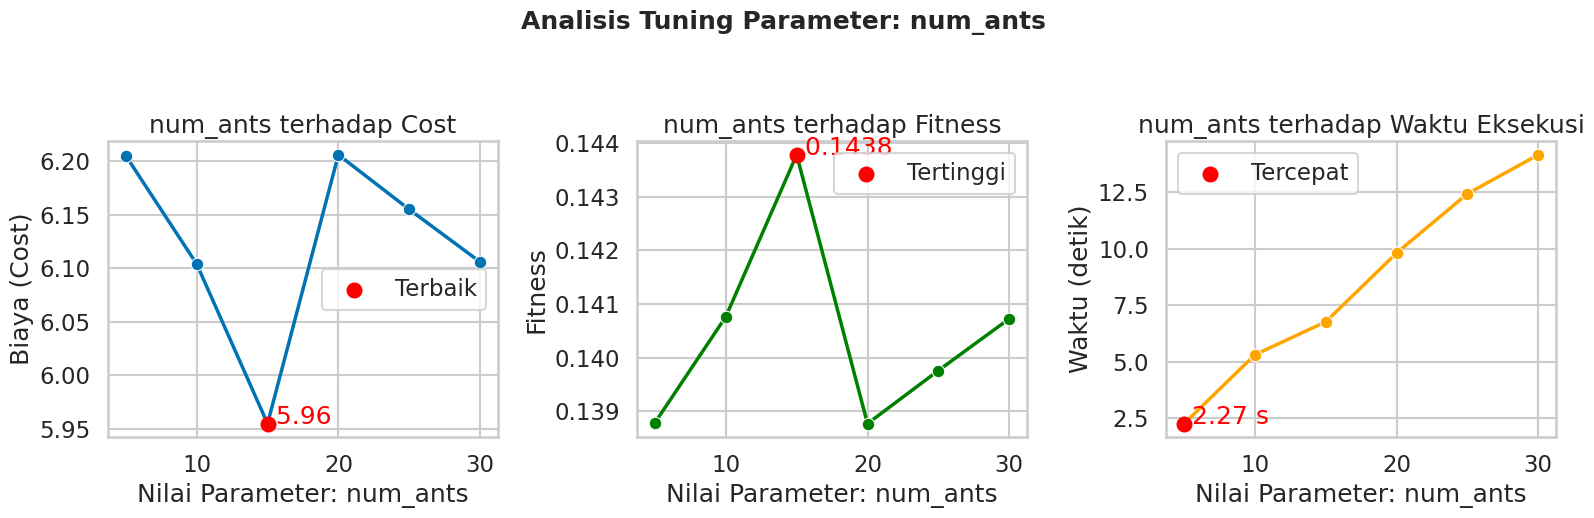

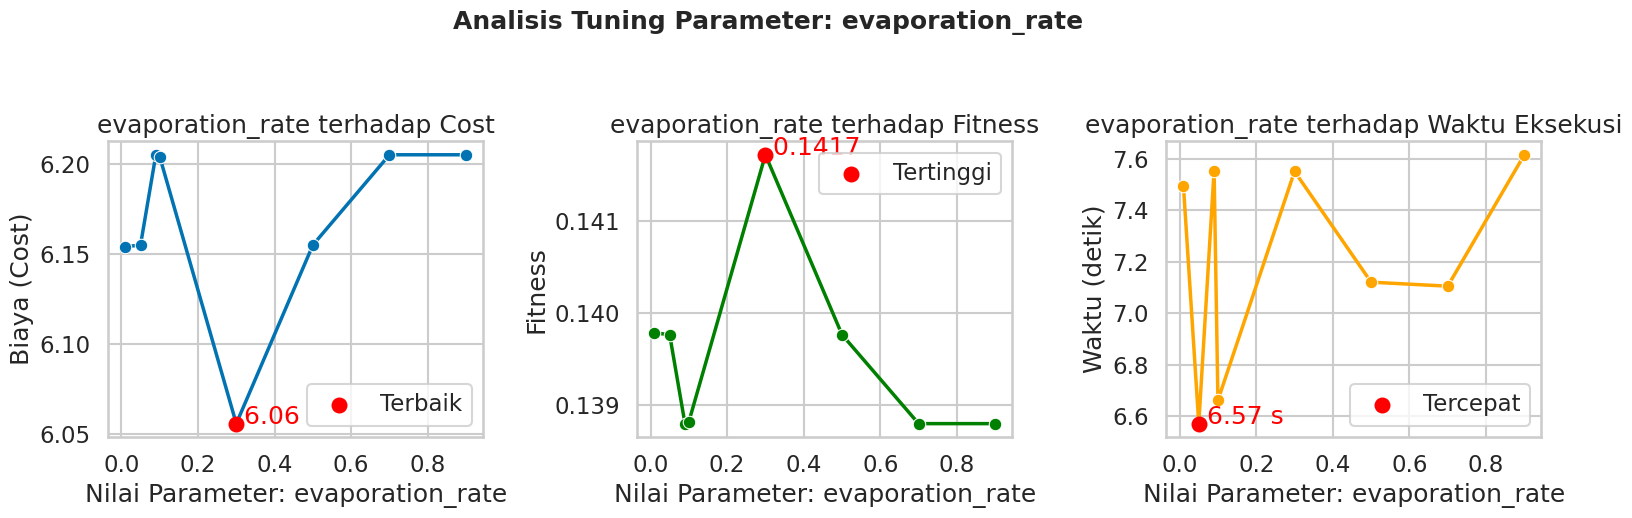

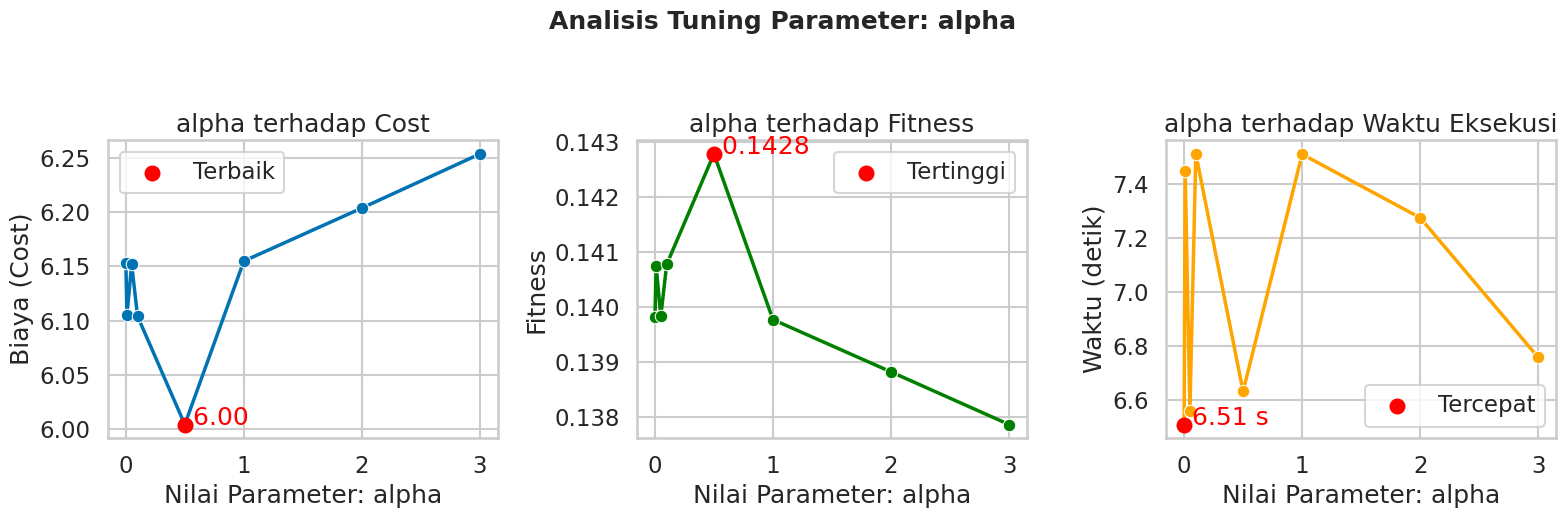

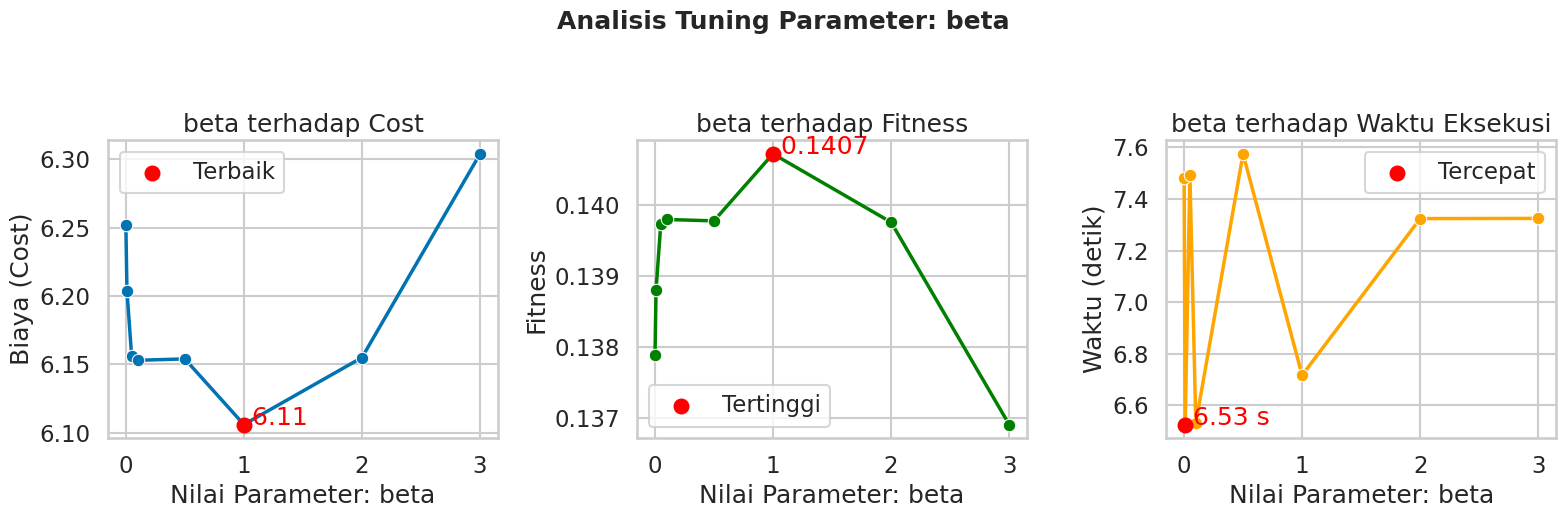

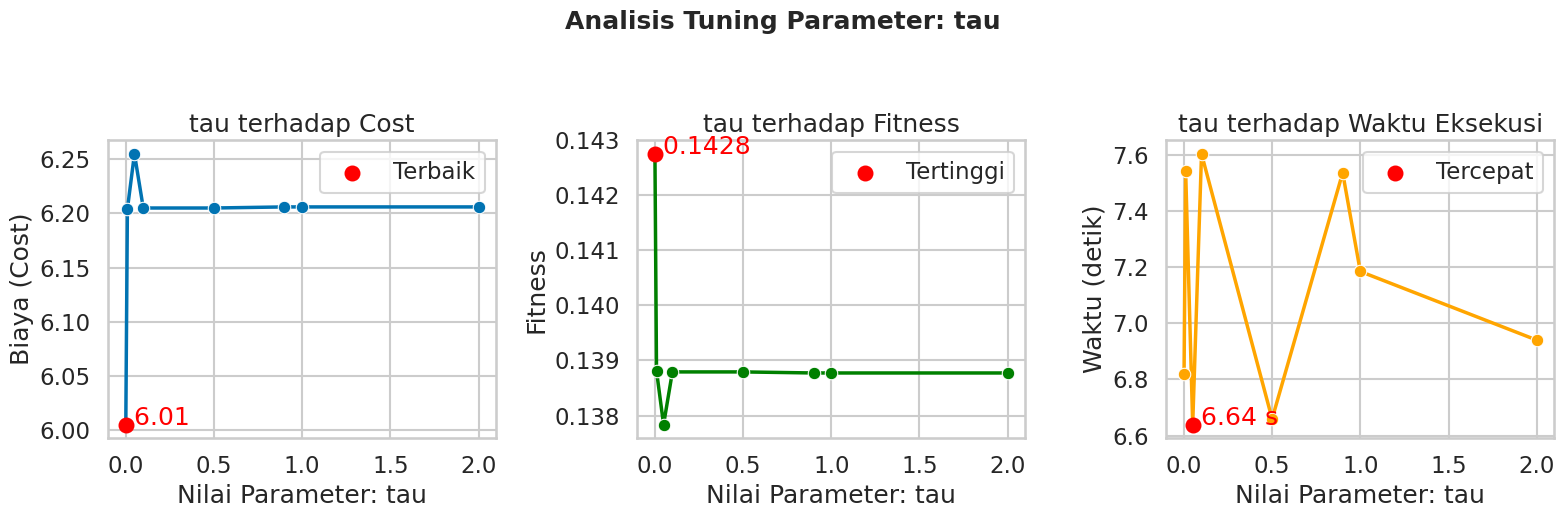

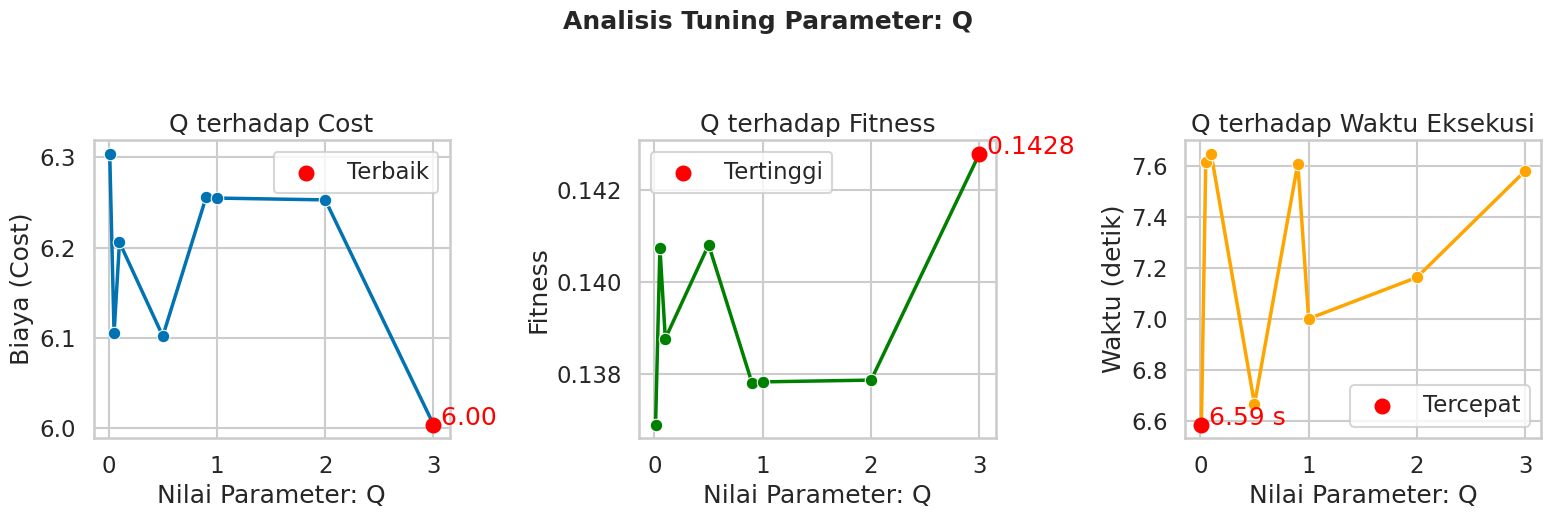

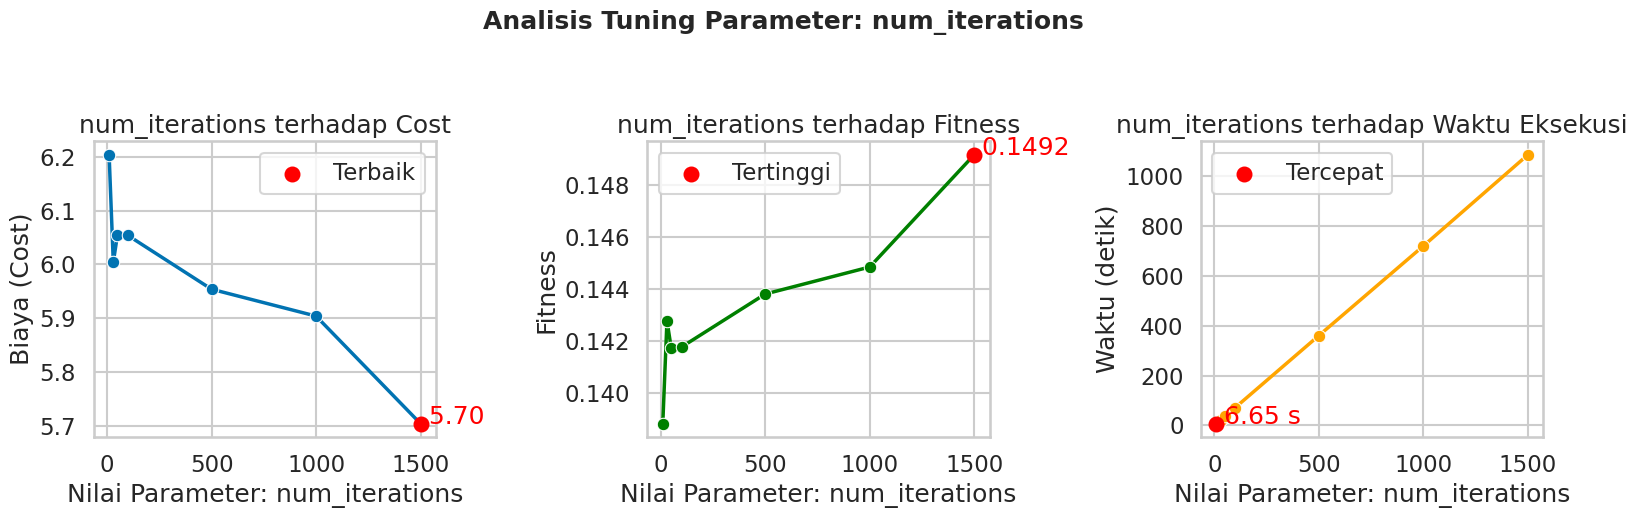

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk", palette="colorblind")  # gaya yang ramah mata

for param_name, df in tuning_logs.items():
    plt.figure(figsize=(16, 5))
    df_sorted = df.sort_values(by='value')

    # --- Best Cost ---
    plt.subplot(1, 3, 1)
    sns.lineplot(x='value', y='cost', data=df_sorted, marker='o', linewidth=2.5)
    best_idx = df_sorted['cost'].idxmin()
    best_val = df_sorted.loc[best_idx, 'value']
    best_cost = df_sorted.loc[best_idx, 'cost']
    plt.scatter(best_val, best_cost, color='red', s=100, zorder=5, label='Terbaik')
    plt.text(best_val, best_cost, f" {best_cost:.2f}", color='red')
    plt.title(f"{param_name} terhadap Cost")
    plt.xlabel(f"Nilai Parameter: {param_name}")
    plt.ylabel("Biaya (Cost)")
    plt.legend()

    # --- Best Fitness ---
    plt.subplot(1, 3, 2)
    sns.lineplot(x='value', y='fitness', data=df_sorted, marker='o', linewidth=2.5, color='green')
    best_idx = df_sorted['fitness'].idxmax()
    best_val = df_sorted.loc[best_idx, 'value']
    best_fitness = df_sorted.loc[best_idx, 'fitness']
    plt.scatter(best_val, best_fitness, color='red', s=100, zorder=5, label='Tertinggi')
    plt.text(best_val, best_fitness, f" {best_fitness:.4f}", color='red')
    plt.title(f"{param_name} terhadap Fitness")
    plt.xlabel(f"Nilai Parameter: {param_name}")
    plt.ylabel("Fitness")
    plt.legend()

    # --- Execution Time ---
    plt.subplot(1, 3, 3)
    sns.lineplot(x='value', y='duration', data=df_sorted, marker='o', linewidth=2.5, color='orange')
    best_idx = df_sorted['duration'].idxmin()
    best_val = df_sorted.loc[best_idx, 'value']
    best_time = df_sorted.loc[best_idx, 'duration']
    plt.scatter(best_val, best_time, color='red', s=100, zorder=5, label='Tercepat')
    plt.text(best_val, best_time, f" {best_time:.2f} s", color='red')
    plt.title(f"{param_name} terhadap Waktu Eksekusi")
    plt.xlabel(f"Nilai Parameter: {param_name}")
    plt.ylabel("Waktu (detik)")
    plt.legend()

    plt.suptitle(f"Analisis Tuning Parameter: {param_name}", fontsize=18, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

In [ ]:
# Simpan ke file
with open("jadwal_ujian.html", "w", encoding="utf-8") as f:
    f.write(html)

In [ ]:
from google.colab import files
files.download("jadwal_ujian.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>